# Import

CSV -> raw `DataFrames`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

In [2]:
sample_information_df = pd.read_csv('sample-information.csv')
mRNA_raw = pd.read_csv('mRNA.csv')
protein_raw = pd.read_csv('protein.csv')
phosphorylated_protein_raw = pd.read_csv('phosphorylated-protein.csv')
metabolites_raw = pd.read_csv('metabolites.csv')

In [ ]:
sample_information_df

In [ ]:
mRNA_raw

In [ ]:
protein_raw

In [ ]:
metabolites_raw

# Subsetting

## Genes/proteins: flavoproteins only

In [3]:
# import
flavoproteins = pd.read_csv('flavoproteins-gudipati2014-ho2018.csv')

# convenience functions --only works for flavoproteins
def sgd_to_ensembl(name):
    return flavoproteins.ensembl_gene_id[flavoproteins.sgd_name == name].to_list()[0]

def ensembl_to_sgd(name):
    return flavoproteins.sgd_name[flavoproteins.ensembl_gene_id == name].to_list()[0]

flavoproteins

,ensembl_gene_id,sgd_name,mean_abundance
0,YKL182W,fas1,"94,906.63"
1,YGR234W,yhb1,"62,330.51"
2,YKL216W,ura1,"54,471.87"
3,YDR032C,pst2,"53,732.70"
4,YDR353W,trr1,"51,642.56"
...,...,...,...
64,YLR047C,fre8,727.63
65,YHR176W,fmo1,531.45
66,YOL152W,fre7,120.35
67,YKL220C,fre2,0.00


In [4]:
mRNA_flavo_bool = mRNA_raw.ensembl_gene_id.apply(lambda x: x in flavoproteins.ensembl_gene_id.to_list())
mRNA_flavo = mRNA_raw[mRNA_flavo_bool]
mRNA_flavo

,ensembl_gene_id,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30
328,YBL098W,0.430686,0.434884,0.439750,0.379694,0.364053,0.400984,0.416997,0.444440,0.461294,...,0.395136,0.407841,0.445476,0.404496,0.403380,0.381694,0.384015,0.396763,0.355489,0.386533
379,YBR035C,0.885585,0.977725,0.996531,0.842167,0.888121,0.862088,0.735050,0.818282,0.832167,...,0.796251,0.830870,0.760834,0.806612,0.873270,0.834971,0.812243,0.873976,0.807530,0.840084
395,YBR052C,0.507767,0.537525,0.553155,0.495360,0.560150,0.632616,0.304660,0.333826,0.343891,...,0.329335,0.351608,0.321824,0.334439,0.443361,0.468630,0.423034,0.479619,0.466368,0.447884
712,YCR004C,0.840844,0.836194,0.866026,0.982462,1.105718,1.080955,0.562746,0.614778,0.593718,...,0.603061,0.626892,0.642110,0.621082,0.678978,0.691814,0.686592,0.688861,0.667808,0.677091
887,YDL085W,0.179626,0.158521,0.173711,0.207118,0.195512,0.202553,0.114267,0.117448,0.115435,...,0.117397,0.116037,0.116673,0.120765,0.122770,0.120943,0.119752,0.126281,0.121666,0.118554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5797,YPL171C,0.149285,0.166136,0.166130,0.143048,0.153147,0.147505,0.121068,0.121779,0.120971,...,0.119771,0.117678,0.120792,0.118429,0.125409,0.121432,0.122504,0.125850,0.124284,0.124321
5830,YPL207W,0.393309,0.415617,0.361459,0.378843,0.381944,0.337053,0.652590,0.641980,0.632660,...,0.462112,0.548960,0.616509,0.542345,0.497709,0.510768,0.486190,0.477262,0.496192,0.503441
5908,YPR004C,0.663954,0.700227,0.675746,0.574761,0.589333,0.566403,0.882418,0.897628,0.864575,...,0.626349,0.820479,0.872964,0.816496,0.714800,0.724598,0.684403,0.638010,0.682900,0.712475
5941,YPR037C,0.270532,0.291320,0.277069,0.252873,0.252301,0.245270,0.297056,0.287912,0.303687,...,0.279708,0.269446,0.287117,0.278616,0.205409,0.235085,0.242264,0.255136,0.270370,0.265837


In [5]:
protein_flavo_bool = protein_raw.ensembl_gene_id.apply(lambda x: x in flavoproteins.ensembl_gene_id.to_list())
protein_flavo = protein_raw[protein_flavo_bool]
protein_flavo

,uniprotswissprot,ensembl_gene_id,S1,S2,S3,S4,S5,S6,S7,S8,...,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30
17,P00175,YML054C,278.139173,383.464950,338.400098,363.582992,394.246718,294.039419,312.244738,361.338700,...,316.741911,304.685353,274.804565,323.589645,265.889006,329.178810,189.311130,348.719122,384.700444,285.771375
147,P07149,YKL182W,1715.839604,1538.604792,1663.688690,1660.401714,1694.169360,1747.113457,1066.109405,1019.822083,...,1155.803199,1010.062098,949.041718,975.598073,1053.521531,1142.147333,1219.363856,1127.078026,1123.187737,1162.170716
179,P07342,YMR108W,3115.199105,3001.784842,3174.122957,3031.746459,3128.677987,3173.525048,3619.384587,3704.212186,...,3215.901503,3312.448544,3519.821297,3333.242860,3381.504703,3438.698904,3539.105268,3407.542904,3440.548436,3467.649975
212,P09624,YFL018C,1688.696022,1646.551546,1729.013953,1699.488327,1718.038961,1721.523146,1797.184708,1856.272116,...,1707.458157,1860.802587,1803.989234,1942.527404,1887.308651,1859.541393,1921.418113,1777.646106,1984.588448,1937.648707
313,P13711,YGL205W,68.517290,59.705900,52.208523,71.990259,43.556291,48.405087,118.599557,61.237310,...,82.602000,42.990940,55.647282,57.433534,74.240670,72.629180,45.091347,101.293323,47.942949,61.163853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,Q12181,YPR048W,16.815414,19.351460,15.299210,16.174430,15.012844,15.884664,20.603062,19.652110,...,15.132001,19.522610,17.962476,17.430359,17.614059,18.487127,18.503018,17.329687,17.095632,16.978208
2560,Q12335,YDR032C,1466.433216,1481.019073,1562.043150,1611.818416,1506.016775,1513.270293,1382.241157,1353.336243,...,1337.234819,1287.583291,1308.886792,1198.322238,1465.025770,1406.122790,1366.843687,1256.422727,1647.495640,1430.196510
2606,Q12480,YPR004C,322.868572,324.252634,346.776600,350.542940,340.305778,332.900255,318.188535,334.296549,...,323.152413,329.220215,327.647164,336.532479,346.185152,354.798794,363.495434,332.689586,356.958946,348.942502
2628,Q12680,YDL171C,480.802683,454.440340,445.743327,449.649530,460.871804,464.168017,307.552500,302.171012,...,377.819442,309.997906,286.294070,321.627173,307.437851,329.396610,354.028864,326.965687,330.014765,321.613280


## Metabolites: lipid only

In [6]:
metabolites_lipid = metabolites_raw[metabolites_raw.super_pathway == 'Lipid']
metabolites_lipid

,metabolite,super_pathway,sub_pathway,S1,S2,S3,S4,S5,S6,S7,...,S21,S22,S23,S24,S25,S26,S27,S28,S29,S30
1,"1,2-dioleoyl-GPC (18:1/18:1)",Lipid,Phosphatidylcholine (PC),0.005285,0.004999,0.012261,0.002643,0.003866,0.005167,0.002382,...,0.001935,0.002747,0.001976,0.001180,0.018137,0.003337,0.005312,0.021848,0.015486,0.017237
2,"1,2-dioleoyl-GPE (18:1/18:1)",Lipid,Phosphatidylethanolamine (PE),0.003450,0.003116,0.005908,0.002219,0.002594,0.004527,0.002037,...,0.002398,0.002677,0.002066,0.001525,0.006960,0.004308,0.005171,0.008232,0.007098,0.006928
3,"1,2-dioleoyl-GPI (18:1/18:1)",Lipid,Phosphatidylinositol (PI),0.003915,0.005287,0.004099,0.004161,0.005086,0.005473,0.005750,...,0.003115,0.003616,0.003103,0.002531,0.003158,0.000413,0.004382,0.003215,0.003496,0.002913
4,"1,2-dipalmitoleoyl-GPC (16:1/16:1)*",Lipid,Phosphatidylcholine (PC),0.005591,0.003164,0.011446,0.003101,0.002930,0.005148,0.002490,...,0.001904,0.002274,0.002303,0.001314,0.015787,0.007511,0.004420,0.018749,0.010949,0.012883
5,"1,2-dipalmitoleoyl-GPE (16:1/16:1)*",Lipid,Phosphatidylethanolamine (PE),0.003520,0.002471,0.005700,0.002348,0.002201,0.003752,0.001686,...,0.001783,0.002495,0.002152,0.001132,0.009494,0.007053,0.004211,0.011124,0.008134,0.008770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,palmitoyl-oleoyl-glycerol (16:0/18:1) [2]*,Lipid,Diacylglycerol,0.001372,0.001658,0.001040,0.003204,0.001025,0.003561,0.004313,...,0.003884,0.003991,0.004166,0.005162,0.002439,0.004388,0.003524,0.002501,0.002966,0.002490
212,palmitoyl-palmitoyl-glycerol (16:0/16:0) [2]*,Lipid,Diacylglycerol,0.001335,0.002896,0.000910,0.001770,0.001415,0.001391,0.001915,...,0.002423,0.003359,0.003018,0.004891,0.000548,0.009757,0.002485,0.000599,0.000579,0.000487
220,phytosphingosine,Lipid,Sphingolipid Metabolism,0.003123,0.002839,0.003062,0.003375,0.003014,0.003267,0.005207,...,0.002775,0.003363,0.003232,0.003168,0.001655,0.003561,0.002648,0.001573,0.002218,0.001779
244,sphinganine,Lipid,Sphingolipid Metabolism,0.001752,0.001976,0.001931,0.001937,0.001954,0.001923,0.005809,...,0.002358,0.002265,0.002547,0.002672,0.001663,0.007698,0.002601,0.001424,0.001935,0.001553


# Data wrangling

(why did they put _all_ replicates into columns is beyond me...)

Intended result

- Only one column on the left that functions as ID
- Rows indicate genes/proteins/metabolites.  Columns indicate time

    - They indicate time rather than time points because time point 7 is inconsistent between replicates.  (Why are they like this?!)
    
- Add a column that corresponds to biological replicate.

In [7]:
# Convert `sample_information_df` to a dictionary: Sample --> replicate & time
# Reason: looking up the sample_information_df every time is slow.
sample_information = dict(zip(
    sample_information_df.Sample.to_list(),
    sample_information_df[['Biological replicate', 'Time after arrest and release (minutes)']].to_numpy().tolist()
))

In [8]:
# massage imported df into the form we want

def df_wrangle(raw_df, id_column):
    '''Massages the imported DataFrames into the form I want
    
    Parameters
    ----------
    raw_df: pandas.DataFrame
        raw imported DataFrame from supplementary information
    id_column: string
        the column to retain to ID the time series
    '''
    # get the columns that don't begin with S
    raw_columns = raw_df.columns.to_list()
    metadata_columns = np.array(raw_columns)[np.invert(np.char.startswith(raw_columns, 'S'))].tolist()
    # melt
    df = raw_df.melt(id_vars = metadata_columns, var_name = 'Sample')
    # convert Sample to replicate and timepoint, using sample_information dictionary
    df = pd.concat(
        [
            df[id_column],
            pd.DataFrame(
                df.Sample.apply(lambda x: sample_information[x]).to_list(),
                columns = ['replicate', 'time']
            ),
            df['value']
        ], axis = 1
    )
    # put id_column, replicate, timepoint into multiindex
    df = pd.DataFrame(
        df.value.to_list(),
        index = pd.MultiIndex.from_frame(df[['replicate', id_column, 'time']]),
        columns = ['value']
    )
    # unstack
    df = df.unstack('time')

    return df

mRNA_df = df_wrangle(mRNA_flavo, 'ensembl_gene_id')
protein_df = df_wrangle(protein_flavo, 'ensembl_gene_id')
phosphorylated_protein_df = df_wrangle(phosphorylated_protein_raw, 'uniprotswissprot_unique')
metabolites_df = df_wrangle(metabolites_lipid, 'metabolite')

In [ ]:
mRNA_df

In [ ]:
protein_df

In [ ]:
phosphorylated_protein_df

In [ ]:
metabolites_df

# Visualisation

Define functions

In [9]:
def plot_genes(df, sgd_name):
    name = sgd_to_ensembl(sgd_name)
    for replicate in [1,2,3]:
        plt.plot(
            df.loc[(replicate, name)].index.get_level_values('time').to_numpy(),
            df.loc[(replicate, name)].to_numpy()
        )
    plt.xlabel('Time (min)')
    plt.ylabel('Expression')
    plt.title(sgd_name)
    plt.show()
    
def plot_replicates(df, name):
    for replicate in [1,2,3]:
        plt.plot(
            df.loc[(replicate, name)].index.get_level_values('time').to_numpy(),
            df.loc[(replicate, name)].to_numpy()
        )
    plt.xlabel('Time (min)')
    plt.ylabel('Expression')
    plt.title(name)
    plt.show()

#plot_genes(mRNA_df, 'fas1')

## mRNA

In [10]:
np.array([ensembl_to_sgd(name) for name in mRNA_df.index.get_level_values('ensembl_gene_id')])

array(['bna4', 'pdx3', 'rfs1', 'ycp4', 'nde2', 'glt1', 'dld1', 'dld2',
       'pst2', 'trr1', 'dld3', 'hem14', 'lpd1', 'met13', 'aro2', 'aim14',
       'pox1', 'mto1', 'erv1', 'erg1', 'yhb1', 'coq6', 'ncp1', 'trr2',
       'fmo1', 'oye2', 'cbr1', 'gut2', 'sdh1b', 'met5', 'cab3', 'sdh1',
       'fas1', 'ura1', 'fre2', 'fre6', 'lot6', 'fre8', 'put1', 'fre1',
       'dus3', 'dus4', 'cyb2', 'dus1', 'alo1', 'ndi1', 'pga3', 'ero1',
       'fms1', 'ilv2', 'nde1', 'dus2', 'fre4', 'emi5', 'cyc2', 'cir2',
       'fre3', 'fre5', 'phr1', 'irc15', 'met12', 'glr1', 'oye3', 'tyw1',
       'aim45', 'erv2', 'tah18', 'bna4', 'pdx3', 'rfs1', 'ycp4', 'nde2',
       'glt1', 'dld1', 'dld2', 'pst2', 'trr1', 'dld3', 'hem14', 'lpd1',
       'met13', 'aro2', 'aim14', 'pox1', 'mto1', 'erv1', 'erg1', 'yhb1',
       'coq6', 'ncp1', 'trr2', 'fmo1', 'oye2', 'cbr1', 'gut2', 'sdh1b',
       'met5', 'cab3', 'sdh1', 'fas1', 'ura1', 'fre2', 'fre6', 'lot6',
       'fre8', 'put1', 'fre1', 'dus3', 'dus4', 'cyb2', 'dus1', 'a

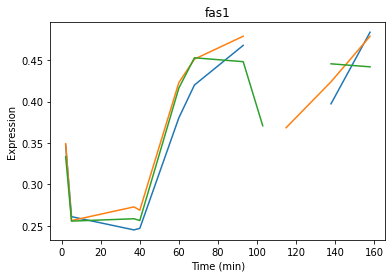

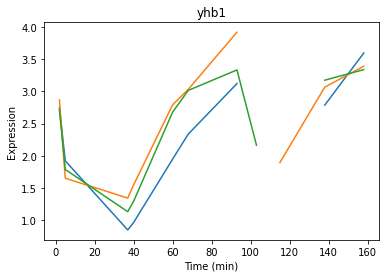

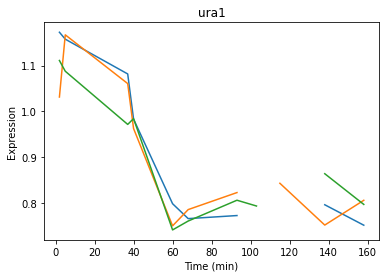

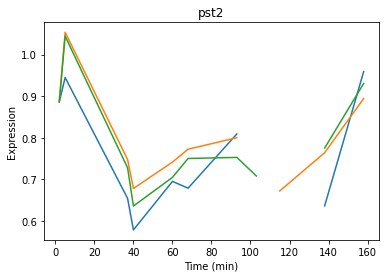

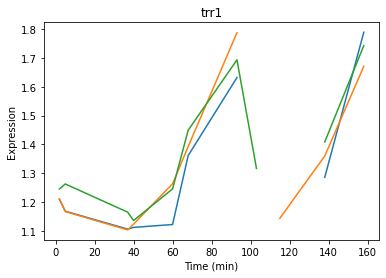

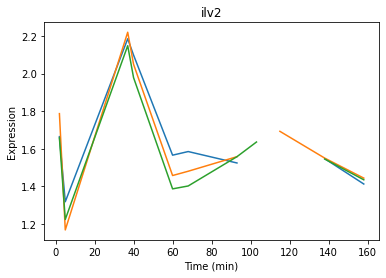

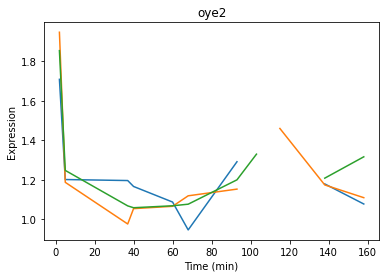

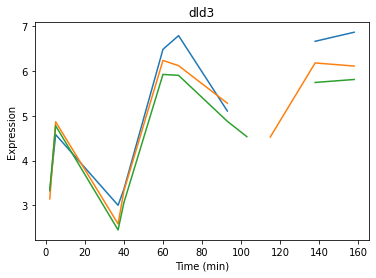

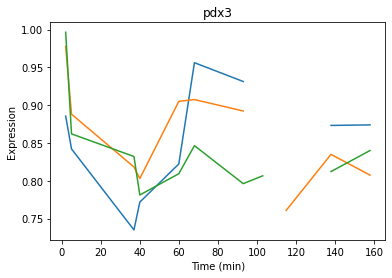

In [11]:
gene_list = ['fas1', 'yhb1', 'ura1', 'pst2', 'trr1', 'ilv2', 'oye2', 'dld3', 'pdx3']

for gene in gene_list:
    plot_genes(mRNA_df, gene)

## Protein

In [12]:
np.array([ensembl_to_sgd(name) for name in protein_df.index.get_level_values('ensembl_gene_id')])

array(['bna4', 'pdx3', 'rfs1', 'ycp4', 'nde2', 'glt1', 'dld1', 'dld2',
       'pst2', 'trr1', 'dld3', 'hem14', 'lpd1', 'met13', 'aro2', 'pox1',
       'mto1', 'erv1', 'erg1', 'yhb1', 'ncp1', 'trr2', 'fmo1', 'oye2',
       'cbr1', 'gut2', 'sdh1b', 'met5', 'cab3', 'sdh1', 'fas1', 'ura1',
       'lot6', 'dus3', 'cyb2', 'dus1', 'alo1', 'ndi1', 'pga3', 'ero1',
       'ilv2', 'nde1', 'dus2', 'emi5', 'cir2', 'met12', 'glr1', 'oye3',
       'tyw1', 'aim45', 'tah18', 'bna4', 'pdx3', 'rfs1', 'ycp4', 'nde2',
       'glt1', 'dld1', 'dld2', 'pst2', 'trr1', 'dld3', 'hem14', 'lpd1',
       'met13', 'aro2', 'pox1', 'mto1', 'erv1', 'erg1', 'yhb1', 'ncp1',
       'trr2', 'fmo1', 'oye2', 'cbr1', 'gut2', 'sdh1b', 'met5', 'cab3',
       'sdh1', 'fas1', 'ura1', 'lot6', 'dus3', 'cyb2', 'dus1', 'alo1',
       'ndi1', 'pga3', 'ero1', 'ilv2', 'nde1', 'dus2', 'emi5', 'cir2',
       'met12', 'glr1', 'oye3', 'tyw1', 'aim45', 'tah18', 'bna4', 'pdx3',
       'rfs1', 'ycp4', 'nde2', 'glt1', 'dld1', 'dld2', 'pst2', 't

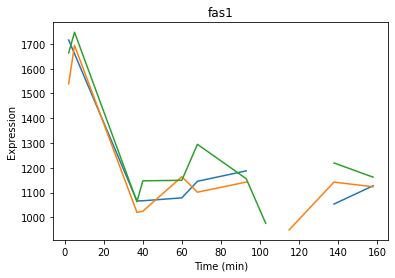

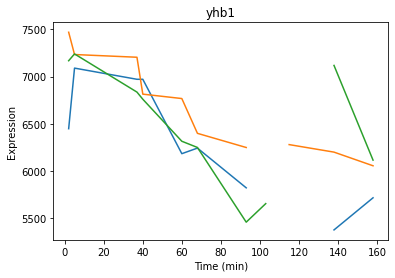

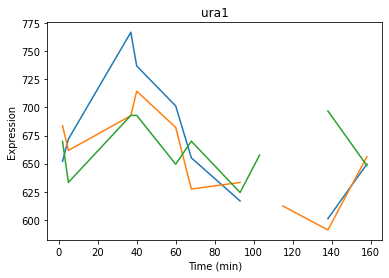

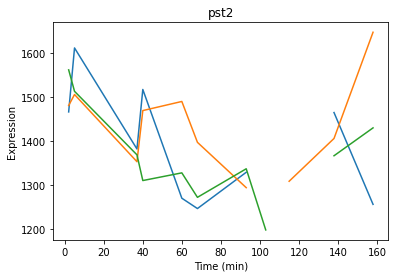

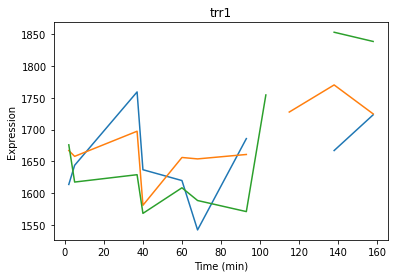

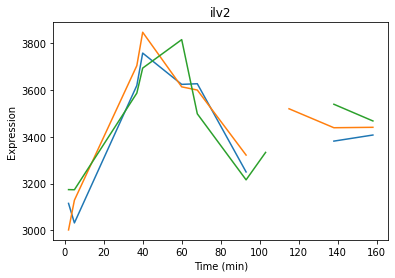

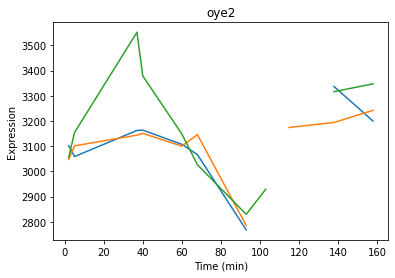

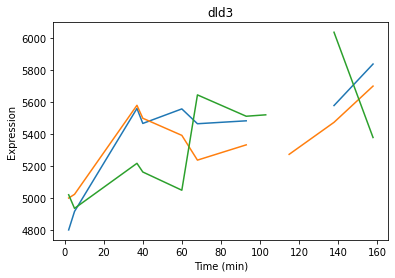

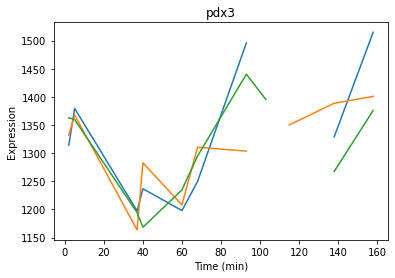

In [13]:
gene_list = ['fas1', 'yhb1', 'ura1', 'pst2', 'trr1', 'ilv2', 'oye2', 'dld3', 'pdx3']

for gene in gene_list:
    plot_genes(protein_df, gene)

## Metabolites

In [14]:
metabolites_df.index.get_level_values('metabolite').to_list()

['1,2-dioleoyl-GPC (18:1/18:1)',
 '1,2-dioleoyl-GPE (18:1/18:1)',
 '1,2-dioleoyl-GPI (18:1/18:1)',
 '1,2-dipalmitoleoyl-GPC (16:1/16:1)*',
 '1,2-dipalmitoleoyl-GPE (16:1/16:1)*',
 '1,2-dipalmitoleoyl-GPI (16:1/16:1)*',
 '1,2-dipalmitoyl-GPC (16:0/16:0)',
 '1-linoleoyl-GPA (18:2)*',
 '1-myristoyl-2-palmitoyl-GPC (14:0/16:0)',
 '1-myristoylglycerol (14:0)',
 '1-oleoyl-GPC (18:1)',
 '1-oleoyl-GPE (18:1)',
 '1-oleoyl-GPI (18:1)*',
 '1-oleoyl-GPS (18:1)',
 '1-palmitoleoyl-2-oleoyl-GPC (16:1/18:1)*',
 '1-palmitoleoyl-2-oleoyl-GPE (16:1/18:1)*',
 '1-palmitoleoyl-2-oleoyl-GPI (16:1/18:1)*',
 '1-palmitoleoyl-GPC (16:1)*',
 '1-palmitoleoylglycerol (16:1)*',
 '1-palmitoyl-2-oleoyl-GPA (16:0/18:1)',
 '1-palmitoyl-2-oleoyl-GPC (16:0/18:1)',
 '1-palmitoyl-2-oleoyl-GPE (16:0/18:1)',
 '1-palmitoyl-2-oleoyl-GPI (16:0/18:1)*',
 '1-palmitoyl-2-oleoyl-GPS (16:0/18:1)',
 '1-palmitoyl-2-palmitoleoyl-GPC (16:0/16:1)*',
 '1-palmitoyl-GPC (16:0)',
 '1-palmitoyl-GPE (16:0)',
 '1-palmitoyl-GPI (16:0)',
 '1-palmi

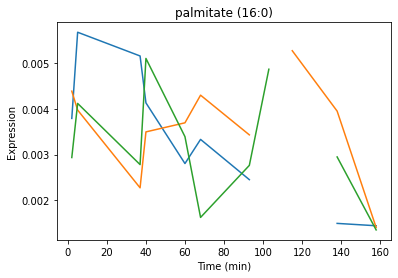

In [15]:
plot_replicates(metabolites_df, 'palmitate (16:0)')